In [1]:
# imports
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import random
import os
import sys
import importlib

from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


sys.path.append("..") # not good
sys.path.append("...") # not good
from tools.data import load_data_simc_v1, load_data_radioml_v1

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"


2023-05-13 18:01:14.073525: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-13 18:01:14.104357: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-13 18:01:14.661880: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-13 18:01:15.996134: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

## Util functions

In [2]:
def set_seed(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

def reload_module(m: str):
    importlib.reload(sys.modules[m])


## Data loading

In [5]:
# Conatans
RADIO_ML_2016_A_DIR = "/development/data/RML2016.10a/RML2016.10a_dict.pkl" # radioml dataset
RADIO_ML_2016_B_DIR = "/development/data/RML2016.10b/RML2016.10b.dat" # radioml dataset
TRAIN_DATA_DIR = RADIO_ML_2016_B_DIR

MODEL_DATA_TYPE = np.float32

SEED = 123456
set_seed(SEED)

In [6]:
# Loading itself
labels, data, modulations = load_data_radioml_v1(TRAIN_DATA_DIR, to_1024=False)
print(modulations)
print(labels.shape)
print(data.shape)

['8PSK', 'QAM64', 'AM-DSB', 'QPSK', 'CPFSK', 'QAM16', 'BPSK', 'PAM4', 'WBFM', 'GFSK']
(1200000,)
(1200000, 1, 128, 2)


In [7]:
# Data Ssplitting
DS_SIZE = len(labels)

n_train = int(0.8 * DS_SIZE)                # 80% - Train
n_validation = int(0.1 * DS_SIZE)           # 10% - Validation
n_test = DS_SIZE - n_train - n_validation   # 10% - Test

random_indecies = np.arange(DS_SIZE)
np.random.shuffle(random_indecies)

train_indecies, validation_indecies, test_indecies, _ = np.split(
    random_indecies, [int(DS_SIZE * 0.8), int(DS_SIZE * 0.9), DS_SIZE]
)

train_data, train_labels = data[train_indecies], labels[train_indecies]
validation_data, validation_labels = data[validation_indecies], labels[validation_indecies]
test_data, test_labels = data[test_indecies], labels[test_indecies]

In [8]:
# Should save some memory
del data
del labels

## Model creation
#### Parts of Encoder

### 1. Multi Head Attention

In [9]:
from tensorflow import math, matmul, reshape, shape, transpose, cast, float32
from tensorflow.keras.layers import Dense, Layer
from keras.backend import softmax

# Implementing the Scaled-Dot Product Attention
class DotProductAttention(Layer):
    def __init__(self, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)

    def call(self, queries, keys, values, d_k, mask=None):
        # Scoring the queries against the keys after transposing the latter, and scaling
        scores = matmul(queries, keys, transpose_b=True) / math.sqrt(cast(d_k, float32))

        # Apply mask to the attention scores
        if mask is not None:
            scores += -1e9 * mask

        # Computing the weights by a softmax operation
        weights = softmax(scores)

        # Computing the attention by a weighted sum of the value vectors
        return matmul(weights, values)

# Implementing the Multi-Head Attention
class SIMC_MultiHeadAttention(Layer):
    def __init__(self, h, d_k, d_v, d_model, **kwargs):
        super(SIMC_MultiHeadAttention, self).__init__(**kwargs)
        self.attention = DotProductAttention()  # Scaled dot product attention
        self.heads = h  # Number of attention heads to use
        self.d_k = d_k  # Dimensionality of the linearly projected queries and keys
        self.d_v = d_v  # Dimensionality of the linearly projected values
        self.d_model = d_model  # Dimensionality of the model
        self.W_q = Dense(d_k)  # Learned projection matrix for the queries
        self.W_k = Dense(d_k)  # Learned projection matrix for the keys
        self.W_v = Dense(d_v)  # Learned projection matrix for the values
        self.W_o = Dense(d_model)  # Learned projection matrix for the multi-head output

    def reshape_tensor(self, x, heads, flag):
        if flag:
            # Tensor shape after reshaping and transposing: (batch_size, heads, seq_length, -1)
            x = reshape(x, shape=(shape(x)[0], shape(x)[1], heads, -1))
            x = transpose(x, perm=(0, 2, 1, 3))
        else:
            # Reverting the reshaping and transposing operations: (batch_size, seq_length, d_k)
            x = transpose(x, perm=(0, 2, 1, 3))
            x = reshape(x, shape=(shape(x)[0], shape(x)[1], self.d_k))
        return x

    def call(self, queries, keys, values, mask=None):
        # Rearrange the queries to be able to compute all heads in parallel
        q_reshaped = self.reshape_tensor(self.W_q(queries), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange the keys to be able to compute all heads in parallel
        k_reshaped = self.reshape_tensor(self.W_k(keys), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange the values to be able to compute all heads in parallel
        v_reshaped = self.reshape_tensor(self.W_v(values), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Compute the multi-head attention output using the reshaped queries, keys and values
        o_reshaped = self.attention(q_reshaped, k_reshaped, v_reshaped, self.d_k, mask)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange back the output into concatenated form
        output = self.reshape_tensor(o_reshaped, self.heads, False)
        # Resulting tensor shape: (batch_size, input_seq_length, d_v)

        # Apply one final linear projection to the output to generate the multi-head attention
        # Resulting tensor shape: (batch_size, input_seq_length, d_model)
        return self.W_o(output)

### 2. Encoder layer and Encoder itself

In [10]:
from tensorflow.keras.layers import LayerNormalization, Layer, Dense, ReLU, Dropout
# from multihead_attention import MultiHeadAttention
# from positional_encoding import PositionEmbeddingFixedWeights

# Implementing the Add & Norm Layer
class AddNormalization(Layer):
    def __init__(self, **kwargs):
        super(AddNormalization, self).__init__(**kwargs)
        self.layer_norm = LayerNormalization()  # Layer normalization layer

    def call(self, x, sublayer_x):
        # The sublayer input and output need to be of the same shape to be summed
        add = x + sublayer_x

        # Apply layer normalization to the sum
        return self.layer_norm(add)

# Implementing the Feed-Forward Layer
class FeedForward(Layer):
    def __init__(self, d_ff, d_model, **kwargs):
        super(FeedForward, self).__init__(**kwargs)
        self.fully_connected1 = Dense(d_ff)  # First fully connected layer
        self.fully_connected2 = Dense(d_model)  # Second fully connected layer
        self.activation = ReLU()  # ReLU activation layer

    def call(self, x):
        # The input is passed into the two fully-connected layers, with a ReLU in between
        x_fc1 = self.fully_connected1(x)

        return self.fully_connected2(self.activation(x_fc1))

# Implementing the Encoder Layer
class EncoderLayer(Layer):
    def __init__(self, h, d_k, d_v, d_model, d_ff, rate, **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)
        self.multihead_attention = SIMC_MultiHeadAttention(h, d_k, d_v, d_model)
        self.dropout1 = Dropout(rate)
        self.add_norm1 = AddNormalization()
        self.feed_forward = FeedForward(d_ff, d_model)
        self.dropout2 = Dropout(rate)
        self.add_norm2 = AddNormalization()

    def call(self, x, padding_mask, training):
        # Multi-head attention layer
        multihead_output = self.multihead_attention(x, x, x, padding_mask)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Add in a dropout layer
        multihead_output = self.dropout1(multihead_output, training=training)

        # Followed by an Add & Norm layer
        addnorm_output = self.add_norm1(x, multihead_output)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Followed by a fully connected layer
        feedforward_output = self.feed_forward(addnorm_output)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Add in another dropout layer
        feedforward_output = self.dropout2(feedforward_output, training=training)

        # Followed by another Add & Norm layer
        return self.add_norm2(addnorm_output, feedforward_output)

# # Implementing the Encoder
# class Encoder(Layer):
#     def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate, **kwargs):
#         super(Encoder, self).__init__(**kwargs)
#         self.pos_encoding = PositionEmbeddingFixedWeights(sequence_length, vocab_size, d_model)
#         self.dropout = Dropout(rate)
#         self.encoder_layer = [EncoderLayer(h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]

#     def call(self, input_sentence, padding_mask, training):
#         # Generate the positional encoding
#         pos_encoding_output = self.pos_encoding(input_sentence)
#         # Expected output shape = (batch_size, sequence_length, d_model)

#         # Add in a dropout layer
#         x = self.dropout(pos_encoding_output, training=training)

#         # Pass on the positional encoded values to each encoder layer
#         for i, layer in enumerate(self.encoder_layer):
#             x = layer(x, padding_mask, training)

#         return x


# Implementing the Encoder
class SIMC_Encoder(Layer):
    def __init__(self, h, d_k, d_v, d_model, d_ff, n, rate, **kwargs):
        super(SIMC_Encoder, self).__init__(**kwargs)
        self.dropout = Dropout(rate)
        self.encoder_layer = [EncoderLayer(h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]

    def call(self, inp, padding_mask, training):
        # Add in a dropout layer
        x = self.dropout(inp, training=training)

        # Pass on the positional encoded values to each encoder layer
        for i, layer in enumerate(self.encoder_layer):
            x = layer(x, padding_mask, training)

        return x

Some utilities for final model


In [11]:
from typing import List
from dataclasses import dataclass

@dataclass
class ConvolutionConfiguration:
    output_channels: List[int]
    kernel_sizes: List[int]
    paddings: List[str]

@dataclass 
class EncoderLayersConfiguration:
    h: int
    d_k: int
    d_v: int
    d_model: int
    d_ff: int
    n: int

@dataclass
class DenseConfiguration:
    sizes: List[int]

### 3. Final model itself
Model constists of a CNNn -> b EncoderLayers -> c Dense layers

In [12]:
def create_model_transformer(
    cnn_conf: ConvolutionConfiguration,
    enc_conf: EncoderLayersConfiguration,
    dense_conf: DenseConfiguration,
    avg_size: int = 32,
    *args,
    **kwargs
):
    if (len(args) != 0):
        print(f"!!! create_model_transformer: unused kwargs: {args}")

    if (len(kwargs) != 0):
        print(f"!!! create_model_transformer: unused kwargs: {kwargs}")

    InputLayer = keras.Input(shape=(128, 2))
    assert len(cnn_conf.output_channels) == len(cnn_conf.kernel_sizes) == len(cnn_conf.paddings)
    N_CNNs = len(cnn_conf.output_channels)
    assert N_CNNs > 0

    CNN1 = layers.Conv1D(
        cnn_conf.output_channels[0], cnn_conf.kernel_sizes[0], padding=cnn_conf.paddings[0], name="CNN1_"
    )(InputLayer)
    RELU1 = layers.ReLU(name="RELU1_")(CNN1)

    model_layers = [CNN1, RELU1]
    for i in range(1, N_CNNs):
        model_layers.append(
            layers.Conv1D(
                cnn_conf.output_channels[i],
                cnn_conf.kernel_sizes[i],
                padding=cnn_conf.paddings[i],
                name=f"CNN{i+1}_",
            )(model_layers[-1])
        )
        model_layers.append(layers.ReLU(name=f"CNN_RELU{i+1}_")(model_layers[-1]))

    enc_conf_dict = enc_conf.__dict__
    model_layers.append(SIMC_Encoder(**enc_conf_dict, rate=0.1, name="ENC1_")(RELU1, None, True))

    model_layers.append(
        layers.AveragePooling1D(avg_size, padding="same", name="AVG1_")(model_layers[-1])
    )

    model_layers.append(layers.Flatten(name="FLT1_")(model_layers[-1]))

    N_Dense = len(dense_conf.sizes)
    assert N_Dense > 0

    model_layers.append(layers.Dense(dense_conf.sizes[0], name="FC1_")(model_layers[-1]))
    model_layers.append(layers.ReLU(name="FC_RELU1_")(model_layers[-1]))

    for i in range(1, N_Dense):
        model_layers.append(layers.Dense(dense_conf.sizes[i], name=f"FC{i+1}_")(model_layers[-1]))
        model_layers.append(layers.ReLU(name=f"FC_RELU{i+1}_")(model_layers[-1]))

    model_layers.append(layers.Dense(len(modulations), name=f"FC_{N_Dense+1}_")(model_layers[-1]))
    Output = layers.Softmax()(model_layers[-1])

    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model

Test code above

In [13]:
model = create_model_transformer(
    ConvolutionConfiguration(output_channels=[32], kernel_sizes=[8], paddings=["same"]),
    EncoderLayersConfiguration(h=4, d_k=32, d_v=32, d_model=32, d_ff=128, n=4),
    DenseConfiguration(sizes=[128])
)
model.summary()

2023-05-13 18:02:07.437211: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-13 18:02:07.437428: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-13 18:02:07.437513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 2)]          0         
                                                                 
 CNN1_ (Conv1D)              (None, 128, 32)           544       
                                                                 
 RELU1_ (ReLU)               (None, 128, 32)           0         
                                                                 
 ENC1_ (SIMC_Encoder)        (None, 128, 32)           50816     
                                                                 
 AVG1_ (AveragePooling1D)    (None, 4, 32)             0         
                                                                 
 FLT1_ (Flatten)             (None, 128)               0         
                                                                 
 FC1_ (Dense)                (None, 128)               16512 

### List of models we're interested at

In [14]:
default_cnn_conf = ConvolutionConfiguration(
    output_channels=[32], kernel_sizes=[9], paddings=["same"]
)
default_encoder_conf = EncoderLayersConfiguration(h=4, d_k=32, d_v=32, d_model=32, d_ff=128, n=4)
default_dense_conf = DenseConfiguration(sizes=[128])
default_avg_size = 32

configs = [
    # [default_cnn_conf, default_encoder_conf, default_dense_conf, default_avg_size, "Default small encoder"],

    # Different kernel sizes
    [ConvolutionConfiguration(output_channels=[32], kernel_sizes=[3], paddings=["same"]), default_encoder_conf, default_dense_conf, default_avg_size, "k=3"],

    # [ConvolutionConfiguration(output_channels=[32], kernel_sizes=[9], paddings=["same"]), default_encoder_conf, default_dense_conf, default_avg_size],

    # [ConvolutionConfiguration(output_channels=[32], kernel_sizes=[17], paddings=["same"]), default_encoder_conf, default_dense_conf, default_avg_size, "k=17"],
    # [ConvolutionConfiguration(output_channels=[32], kernel_sizes=[33], paddings=["same"]), default_encoder_conf, default_dense_conf, default_avg_size, "k=33"],
    # [ConvolutionConfiguration(output_channels=[32], kernel_sizes=[65], paddings=["same"]), default_encoder_conf, default_dense_conf, default_avg_size, "k=65"],

    # Different number of encoder layers

    # [default_cnn_conf, EncoderLayersConfiguration(h=4, d_k=32, d_v=32, d_model=32, d_ff=128, n=2), default_dense_conf, default_avg_size, "encoder n=2"],

    # [default_cnn_conf, EncoderLayersConfiguration(h=4, d_k=32, d_v=32, d_model=32, d_ff=128, n=4), default_dense_conf, default_avg_size],

    # [default_cnn_conf, EncoderLayersConfiguration(h=4, d_k=32, d_v=32, d_model=32, d_ff=128, n=6), default_dense_conf, default_avg_size, "encoder n=6"],
    # [default_cnn_conf, EncoderLayersConfiguration(h=4, d_k=32, d_v=32, d_model=32, d_ff=128, n=8), default_dense_conf, default_avg_size, "encoder n=8"],

    # Different sizes of d_model
    # [ConvolutionConfiguration(output_channels=[32], kernel_sizes=[9], paddings=["same"]),  EncoderLayersConfiguration(h=4, d_k=32, d_v=32, d_model=32, d_ff=128, n=4), default_dense_conf, default_avg_size],

    # [ConvolutionConfiguration(output_channels=[64], kernel_sizes=[9], paddings=["same"]),  EncoderLayersConfiguration(h=4, d_k=32, d_v=32, d_model=64, d_ff=128, n=4), default_dense_conf, default_avg_size, "d_model=64"],
    [ConvolutionConfiguration(output_channels=[128], kernel_sizes=[9], paddings=["same"]),  EncoderLayersConfiguration(h=4, d_k=32, d_v=32, d_model=128, d_ff=128, n=4), default_dense_conf, default_avg_size, "d_model=128"],
    # [ConvolutionConfiguration(output_channels=[256], kernel_sizes=[9], paddings=["same"]),  EncoderLayersConfiguration(h=4, d_k=32, d_v=32, d_model=256, d_ff=128, n=4), default_dense_conf, default_avg_size, "d_model=256"],
]

# for config in configs:
#     print(config)
#     model = create_model_transformer(*config)
#     model.summary()

### Model evaluation functions

In [15]:
import pickle

def evaluate_model(model, data, labels, verbose=True):
    preds = model.predict(data)
    pred_labels = np.argmax(preds, axis=1)

    cls_to_acc = {"Overall": accuracy_score(labels, pred_labels)}
    print(f"Overall test accuracy: {cls_to_acc}")
    for ci, cl in enumerate(modulations):
        class_indecies = np.where(labels == ci)[0]
        cur_true_labels = labels[class_indecies]
        cur_pred_labels = pred_labels[class_indecies]
        cls_to_acc[cl] = accuracy_score(cur_true_labels, cur_pred_labels)
        verbose and print(f"{cl} test accuracy: {cls_to_acc[cl]}")
    cm = confusion_matrix(y_true=labels, y_pred=pred_labels)
    verbose and print(cm)
    df_cm = pd.DataFrame(cm, index = modulations,
                    columns = modulations)
    if verbose:
        plt.figure(figsize = (10,7))
        sn.heatmap(df_cm, annot=True)
    return cm, cls_to_acc


def get_snrs(indecies, to_1024=False, minimum_snr=-100):
    with open(TRAIN_DATA_DIR, 'rb') as crmrn_file:
        raw_ds = pickle.load(crmrn_file, encoding="bytes")
    decoded_raw_ds = {}
    for (class_name_bytes, snr), raw_data in raw_ds.items():
        if snr < minimum_snr:
            continue
        decoded_raw_ds[(class_name_bytes.decode("utf-8"), snr)] = raw_data
    raw_ds = decoded_raw_ds

    samples_per_snr_per_modulation = raw_ds[list(raw_ds.keys())[0]].shape[0] # 1000
    snrs_sequence = [k[1] for k in raw_ds.keys()]
    result = []
    snrs = [snrs_sequence[idx // samples_per_snr_per_modulation] for idx in indecies]
    return np.array(snrs)


def get_snr_to_acc(model, data, labels, snrs, verbose=True):
    snr_to_acc = {}
    for snr in range(min(snrs), max(snrs)+2, 2):
        cur_indecies = np.where(snrs == snr)[0]
        cur_data = data[cur_indecies]
        cur_labels = labels[cur_indecies]
        cur_pred = model.predict(cur_data, verbose=0)

        cur_pred_labels = np.argmax(cur_pred, axis=1)
        verbose and print(f"snr={snr}")
        acc = accuracy_score(cur_labels, cur_pred_labels)
        verbose and print(f"Overall test accuracy: {acc}")
        snr_to_acc[snr] = acc
    return snr_to_acc

### Train, evaluate, save model and evaluation results

In [20]:
import json
from copy import deepcopy

train_data = train_data.squeeze()
validation_data = validation_data.squeeze()
test_data = test_data.squeeze()

# configs = [
#     [
#         default_cnn_conf,
#         EncoderLayersConfiguration(h=4, d_k=32, d_v=32, d_model=32, d_ff=128, n=2),
#         default_dense_conf,
#         default_avg_size,
#         "n=2"
#     ],
#     [
#         default_cnn_conf,
#         EncoderLayersConfiguration(h=4, d_k=32, d_v=32, d_model=32, d_ff=128, n=2),
#         default_dense_conf,
#         64,
#         "n=2, pool size=64"
#     ],
# ]

for i, config in enumerate(configs):
    if i == 0:
        continue
    model = create_model_transformer(*config)
    model.summary()

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        # optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    N_EPOCHS = 40
    # N_EPOCHS = 1
    BATCH_SIZE = 128

    h = model.fit(
        train_data,
        train_labels,
        epochs=N_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(validation_data, validation_labels),
        # callbacks=[lrate]
    )

    cm_val, cls_to_acc_val = evaluate_model(
        model, validation_data, validation_labels, verbose=False
    )
    snrs_val = get_snrs(validation_indecies, False)
    snr_to_acc_val = get_snr_to_acc(
        model, validation_data, validation_labels, snrs_val, verbose=False
    )

    cm_test, cls_to_acc_test = evaluate_model(model, test_data, test_labels, verbose=False)
    snr_tests = get_snrs(test_indecies, False)
    snr_to_acc_test = get_snr_to_acc(model, test_data, test_labels, snr_tests, verbose=False)

    results_dir = f"encoder_radio_ML_B/experiment_{i}/"
    model_configuration = {
        "cnn": config[0].__dict__,
        "encoder": config[1].__dict__,
        "dense": config[2].__dict__,
        "avg_pool": config[3],
        "description": config[4]
    }
    
    train_history = deepcopy(h.history)
    # train_history["lr"] = [float(lr) for lr in train_history["lr"]]

    results = {
        "model_configuration": model_configuration,
        "train_history": h.history,
        "cm_val": cm_val.tolist(),
        "cls_to_acc_val": cls_to_acc_val,
        "snr_to_acc_val": snr_to_acc_val,
        "cm_test": cm_test.tolist(),
        "cls_to_acc_test": cls_to_acc_test,
        "snr_to_acc_test": snr_to_acc_test,
    }

    os.makedirs(results_dir, exist_ok=True)
    with open(results_dir + "results.json", "w") as res_file:
        json.dump(results, res_file, indent=4)
    model.save(results_dir + "model")

!!! create_model_transformer: unused kwargs: ('d_model=128',)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 2)]          0         
                                                                 
 CNN1_ (Conv1D)              (None, 128, 128)          2432      
                                                                 
 RELU1_ (ReLU)               (None, 128, 128)          0         
                                                                 
 ENC1_ (SIMC_Encoder)        (None, 128, 128)          200576    
                                                                 
 AVG1_ (AveragePooling1D)    (None, 4, 128)            0         
                                                                 
 FLT1_ (Flatten)             (None, 512)               0         
                                                               

2023-05-14 00:27:34.083966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inp' with dtype float and shape [?,128,128]
	 [[{{node inp}}]]
2023-05-14 00:27:34.112343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inp' with dtype float and shape [?,128,128]
	 [[{{node inp}}]]
2023-05-14 00:27:35.596608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inp' with dtype float and shape [?,128,128]
	 [[{{node inp}}]]
2023-05-14 00:27:35.62

INFO:tensorflow:Assets written to: encoder_radio_ML_B/experiment_1/model/assets


INFO:tensorflow:Assets written to: encoder_radio_ML_B/experiment_1/model/assets


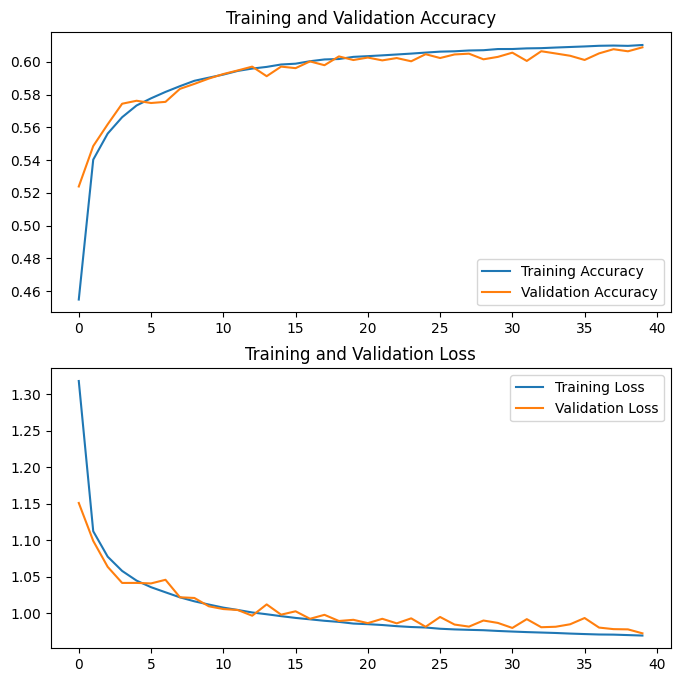

In [19]:
import matplotlib.pyplot as plt

acc = h.history['accuracy']
val_acc = h.history['val_accuracy']
loss = h.history['loss']
val_loss = h.history['val_loss']

epochs_range = range(N_EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()